<a href="https://colab.research.google.com/github/PimiYvan/proto_adaptation/blob/main/vdb_only_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the Meta-Dataset Data Pipeline

This notebook shows how to use `meta_dataset`’s input pipeline to sample data for the Meta-Dataset benchmark. There are two main ways in which data is sampled:
1. **episodic**:  Returns N-way classification *episodes*, which contain a *support* (training) set and a *query* (test) set. The number of classes (N) may vary from episode to episode.
2. **batch**:  Returns batches of images and their corresponding label, sampled from all available classes.

We first import `meta_dataset` and other required packages, and define utility functions for visualization. We’ll make use of `meta_dataset.data.learning_spec` and `meta_dataset.data.pipeline`; their purpose will be made clear later on.

In [ ]:
!git clone https://github.com/google-research/meta-dataset.git
!cp -r "/content/meta-dataset/meta_dataset" "/content/"
!cd meta-dataset/ && python3 setup.py install

Cloning into 'meta-dataset'...
remote: Enumerating objects: 3060, done.
remote: Counting objects: 100% (830/830), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 3060 (delta 729), reused 720 (delta 703), pack-reused 2230
Receiving objects: 100% (3060/3060), 3.32 MiB | 4.85 MiB/s, done.
Resolving deltas: 100% (2305/2305), done.
running install
running simclr_download
running build
running build_py
creating build/lib/meta_dataset
copying meta_dataset/analyze.py -> build/lib/meta_dataset
copying meta_dataset/distribute_utils.py -> build/lib/meta_dataset
copying meta_dataset/__init__.py -> build/lib/meta_dataset
copying meta_dataset/test_utils.py -> build/lib/meta_dataset
copying meta_dataset/train.py -> build/lib/meta_dataset
copying meta_dataset/trainer.py -> build/lib/meta_dataset
copying meta_dataset/trainer_flute.py -> build/lib/meta_dataset
copying meta_dataset/trainer_test.py -> build/lib/meta_dataset
copying meta_dataset/train_flute.py -> build/lib/meta_datas

Imports and Utility Functions

In [ ]:
#@title Imports and Utility Functions
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from collections import Counter
import gin
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from meta_dataset.data import config
from meta_dataset.data import dataset_spec as dataset_spec_lib
from meta_dataset.data import learning_spec
from meta_dataset.data import pipeline
import matplotlib.pyplot as plt
import torch

def plot_episode(support_images, support_class_ids, query_images,
                 query_class_ids, size_multiplier=1, max_imgs_per_col=10,
                 max_imgs_per_row=10):
  for name, images, class_ids in zip(('Support', 'Query'),
                                     (support_images, query_images),
                                     (support_class_ids, query_class_ids)):
    n_samples_per_class = Counter(class_ids)
    n_samples_per_class = {k: min(v, max_imgs_per_col)
                           for k, v in n_samples_per_class.items()}
    id_plot_index_map = {k: i for i, k
                         in enumerate(n_samples_per_class.keys())}
    num_classes = min(max_imgs_per_row, len(n_samples_per_class.keys()))
    max_n_sample = max(n_samples_per_class.values())
    figwidth = max_n_sample
    figheight = num_classes
    
    if name == 'Support':
      print('#Classes: %d' % len(n_samples_per_class.keys()))
    figsize = (figheight * size_multiplier, figwidth * size_multiplier)
    fig, axarr = plt.subplots(
        figwidth, figheight, figsize=figsize)
    fig.suptitle('%s Set' % name, size='20')
    fig.tight_layout(pad=3, w_pad=0.1, h_pad=0.1)
    reverse_id_map = {v: k for k, v in id_plot_index_map.items()}
    for i, ax in enumerate(axarr.flat):
      ax.patch.set_alpha(0)
      # Print the class ids, this is needed since, we want to set the x axis
      # even there is no picture.
      ax.set(xlabel=reverse_id_map[i % figheight], xticks=[], yticks=[])
      ax.label_outer()
    for image, class_id in zip(images, class_ids):
      # First decrement by one to find last spot for the class id.
      n_samples_per_class[class_id] -= 1
      # If class column is filled or not represented: pass.
      if (n_samples_per_class[class_id] < 0 or
          id_plot_index_map[class_id] >= max_imgs_per_row):
        continue
      # If width or height is 1, then axarr is a vector.
      if axarr.ndim == 1:
        ax = axarr[n_samples_per_class[class_id]
                   if figheight == 1 else id_plot_index_map[class_id]]
      else:
        ax = axarr[n_samples_per_class[class_id], id_plot_index_map[class_id]]
      ax.imshow(image / 2 + 0.5)
    plt.show()


def plot_batch(images, labels, size_multiplier=1):
  num_examples = len(labels)
  figwidth = np.ceil(np.sqrt(num_examples)).astype('int32')
  figheight = num_examples // figwidth
  figsize = (figwidth * size_multiplier, (figheight + 1.5) * size_multiplier)
  _, axarr = plt.subplots(figwidth, figheight, dpi=300, figsize=figsize)

  for i, ax in enumerate(axarr.transpose().ravel()):
    # Images are between -1 and 1.
    ax.imshow(images[i] / 2 + 0.5)
    ax.set(xlabel=labels[i], xticks=[], yticks=[])
  plt.show()

# Primers
1. Download your data and process it as explained in [link](https://github.com/google-research/meta-dataset/blob/main/README.md#downloading-and-converting-datasets). Set `BASE_PATH` pointing the processed tf-records (`$RECORDS` in the conversion instructions).
2. `meta_dataset` supports many different setting for sampling data. We use [gin-config](https://github.com/google/gin-config) to control default parameters of our functions. You can go to default gin file we are pointing and see the default values.
3. You can use `meta_dataset` in **eager** or **graph** mode.
4. Let's write a generator that makes the right calls to return data from dataset. `dataset.make_one_shot_iterator()` returns an iterator where each element is an episode.
4. SPLIT is used to define which part of the meta-split is going to be used. Different splits have different classes and the details on how they are created can be found in the [paper](https://arxiv.org/abs/1903.03096).

In [ ]:
!mkdir records
!mkdir datasrc
!mkdir splits


In [ ]:
!mkdir "/content/datasrc/vgg_flower/"

# Vgg Flower
!wget "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
!wget "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

!tar -xvzf 102flowers.tgz


!mv "/content/jpg" "/content/datasrc/vgg_flower"
!mv "/content/imagelabels.mat" "/content/datasrc/vgg_flower"

!rm 102flowers.tgz 

Streaming output truncated to the last 5000 lines.
jpg/image_02266.jpg
jpg/image_00062.jpg
jpg/image_05821.jpg
jpg/image_03712.jpg
jpg/image_01142.jpg
jpg/image_03033.jpg
jpg/image_05760.jpg
jpg/image_02732.jpg
jpg/image_00183.jpg
jpg/image_05264.jpg
jpg/image_03778.jpg
jpg/image_07061.jpg
jpg/image_04468.jpg
jpg/image_00676.jpg
jpg/image_07610.jpg
jpg/image_02192.jpg
jpg/image_05112.jpg
jpg/image_05638.jpg
jpg/image_00053.jpg
jpg/image_02451.jpg
jpg/image_05857.jpg
jpg/image_08033.jpg
jpg/image_03902.jpg
jpg/image_07494.jpg
jpg/image_02357.jpg
jpg/image_05496.jpg
jpg/image_04496.jpg
jpg/image_07538.jpg
jpg/image_01801.jpg
jpg/image_00326.jpg
jpg/image_07644.jpg
jpg/image_01199.jpg
jpg/image_01168.jpg
jpg/image_07020.jpg
jpg/image_05006.jpg
jpg/image_03484.jpg
jpg/image_02825.jpg
jpg/image_04549.jpg
jpg/image_02011.jpg
jpg/image_04360.jpg
jpg/image_06847.jpg
jpg/image_07695.jpg
jpg/image_03540.jpg
jpg/image_08058.jpg
jpg/image_01230.jpg
jpg/image_00096.jpg
jpg/image_01517.jpg
jpg/image

In [ ]:
!mkdir "/content/datasrc/omniglot/"

# omniglot
!wget "https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip"
!wget "https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip"

!unzip images_background.zip
!unzip images_evaluation.zip

!mv "/content/images_background" "/content/datasrc/omniglot/images_background/"
!mv "/content/images_evaluation" "/content/datasrc/omniglot/images_evaluation/"

!rm images_background.zip images_evaluation.zip


Streaming output truncated to the last 5000 lines.
  inflating: images_evaluation/Mongolian/character28/1386_05.png  
  inflating: images_evaluation/Mongolian/character28/1386_06.png  
  inflating: images_evaluation/Mongolian/character28/1386_07.png  
  inflating: images_evaluation/Mongolian/character28/1386_08.png  
  inflating: images_evaluation/Mongolian/character28/1386_09.png  
  inflating: images_evaluation/Mongolian/character28/1386_10.png  
  inflating: images_evaluation/Mongolian/character28/1386_11.png  
  inflating: images_evaluation/Mongolian/character28/1386_12.png  
  inflating: images_evaluation/Mongolian/character28/1386_13.png  
  inflating: images_evaluation/Mongolian/character28/1386_14.png  
  inflating: images_evaluation/Mongolian/character28/1386_15.png  
  inflating: images_evaluation/Mongolian/character28/1386_16.png  
  inflating: images_evaluation/Mongolian/character28/1386_17.png  
  inflating: images_evaluation/Mongolian/character28/1386_18.png  
  inflating

In [ ]:

!mkdir -p "/content/datasrc/fungi/images/"

# fungi
!wget "https://labs.gbif.org/fgvcx/2018/fungi_train_val.tgz"
!wget "https://labs.gbif.org/fgvcx/2018/train_val_annotations.tgz"

!tar -xvzf fungi_train_val.tgz
!tar -xvzf train_val_annotations.tgz

!mv "/content/images" "/content/datasrc/fungi/"
# !mv "/content/images" "/content/datasrc/fungi/" # old way

!mv "/content/train.json" "/content/datasrc/fungi/"
!mv "/content/val.json" "/content/datasrc/fungi/"

!rm fungi_train_val.tgz train_val_annotations.tgz


Streaming output truncated to the last 5000 lines.
images/18882_Plicatura_crispa/JAJ2017-9187404_rJe8AnKx9g.JPG
images/18882_Plicatura_crispa/MACH2016-9181621_Hyes6kkFge.JPG
images/18882_Plicatura_crispa/TS2010PIC88793082.JPG
images/18882_Plicatura_crispa/BEC2016-9184359_rylujfugNl.JPG
images/18882_Plicatura_crispa/FS2016-9183584_Skl1y3eRfg.JPG
images/18882_Plicatura_crispa/HM2013PIC24753652.JPG
images/18882_Plicatura_crispa/FDE2014PIC84467705.JPG
images/18882_Plicatura_crispa/BWP2017-9186209_H11yy9fwx.JPG
images/18882_Plicatura_crispa/BWP2013PIC43351968.JPG
images/18882_Plicatura_crispa/BWP2010PIC63740443.JPG
images/18882_Plicatura_crispa/MC2017-9228314_r1g3P-AEpW.JPG
images/18882_Plicatura_crispa/LKT2013PIC28156077.JPG
images/18882_Plicatura_crispa/BWP2013PIC47430367.JPG
images/18882_Plicatura_crispa/TOB2016-9183645_HJMoLnbXl.JPG
images/18882_Plicatura_crispa/JHV2015PIC48914651.JPG
images/18882_Plicatura_crispa/JM2016-9176164_Hy4WhawT.JPG
images/18882_Plicatura_crispa/ML2015PIC763368

In [ ]:
#fungi/images/12494_Cortinarius_malicorius/MMN2009PIC16410851.JPG; 
# DTD
!wget "https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz"
!tar -xvzf dtd-r1.0.1.tar.gz
!mv "/content/dtd" "/content/datasrc/"

!rm dtd-r1.0.1.tar.gz

Streaming output truncated to the last 5000 lines.
dtd/images/porous/porous_0122.jpg
dtd/images/porous/porous_0156.jpg
dtd/images/porous/porous_0091.jpg
dtd/images/porous/porous_0083.jpg
dtd/images/porous/porous_0124.jpg
dtd/images/porous/porous_0151.jpg
dtd/images/porous/porous_0131.jpg
dtd/images/porous/porous_0096.jpg
dtd/images/porous/porous_0153.jpg
dtd/images/porous/porous_0154.jpg
dtd/images/porous/porous_0052.jpg
dtd/images/porous/porous_0172.jpg
dtd/images/porous/porous_0044.jpg
dtd/images/porous/porous_0118.jpg
dtd/images/porous/porous_0140.jpg
dtd/images/porous/porous_0152.jpg
dtd/images/porous/porous_0171.jpg
dtd/images/porous/porous_0132.jpg
dtd/images/porous/porous_0105.jpg
dtd/images/porous/porous_0127.jpg
dtd/images/porous/porous_0130.jpg
dtd/images/porous/porous_0104.jpg
dtd/images/porous/porous_0066.jpg
dtd/images/porous/porous_0158.jpg
dtd/images/porous/porous_0128.jpg
dtd/images/porous/porous_0138.jpg
dtd/images/porous/porous_0133.jpg
dtd/images/porous/porous_0050.j

In [ ]:
#CU BIRDS
# !wget "http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz"
!wget "https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz"
!tar -xvzf CUB_200_2011.tgz
!mv "/content/CUB_200_2011" "/content/datasrc/"
!rm CUB_200_2011.tgz

!mv "/content/attributes.txt" "/content/datasrc/CUB_200_2011/"

In [ ]:
# AIRCRAFT
!wget "http://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz" 
!tar -xvzf fgvc-aircraft-2013b.tar.gz
!mv "/content/fgvc-aircraft-2013b" "/content/datasrc/"
!rm fgvc-aircraft-2013b.tar.gz

Streaming output truncated to the last 5000 lines.
fgvc-aircraft-2013b/data/images/0716452.jpg
fgvc-aircraft-2013b/data/images/0683550.jpg
fgvc-aircraft-2013b/data/images/0192881.jpg
fgvc-aircraft-2013b/data/images/0818052.jpg
fgvc-aircraft-2013b/data/images/0744239.jpg
fgvc-aircraft-2013b/data/images/2170875.jpg
fgvc-aircraft-2013b/data/images/1256475.jpg
fgvc-aircraft-2013b/data/images/2075105.jpg
fgvc-aircraft-2013b/data/images/0962825.jpg
fgvc-aircraft-2013b/data/images/1641331.jpg
fgvc-aircraft-2013b/data/images/1426707.jpg
fgvc-aircraft-2013b/data/images/1312743.jpg
fgvc-aircraft-2013b/data/images/1391858.jpg
fgvc-aircraft-2013b/data/images/0184346.jpg
fgvc-aircraft-2013b/data/images/0894188.jpg
fgvc-aircraft-2013b/data/images/1852173.jpg
fgvc-aircraft-2013b/data/images/0767364.jpg
fgvc-aircraft-2013b/data/images/1148366.jpg
fgvc-aircraft-2013b/data/images/0773403.jpg
fgvc-aircraft-2013b/data/images/1308386.jpg
fgvc-aircraft-2013b/data/images/1375264.jpg
fgvc-aircraft-2013b/data/

In [ ]:
# 1
BASE_PATH = 'records'
GIN_FILE_PATH = 'meta_dataset/learn/gin/setups/data_config.gin'
# GIN_FILE_PATH = 'meta-dataset/meta_dataset/learn/gin/setups/data_config.gin'

# 2
gin.parse_config_file(GIN_FILE_PATH)
# 3

# Comment out to disable eager execution.
# tf.enable_eager_execution()

# 4
def iterate_dataset(dataset, n):
  if not tf.executing_eagerly():
    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    with tf.Session() as sess:
      for idx in range(n):
        yield idx, sess.run(next_element)
  else:
    for idx, episode in enumerate(dataset):
      if idx == n:
        break
      yield idx, episode
      
# 5
# SPLIT = learning_spec.Split.TRAIN # use meta testing 
SPLIT = learning_spec.Split.TEST # use meta testing 
print(SPLIT, type(SPLIT))

In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=vgg_flower \
  --vgg_flower_data_root=/content/datasrc/vgg_flower \
  --splits_root=/content/splits \
  --records_root=/content/records 

In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=omniglot \
  --omniglot_data_root=/content/datasrc/omniglot \
  --splits_root=/content/splits \
  --records_root=/content/records 

2023-03-06 06:14:49.204181: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-06 06:14:49.204413: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-06 06:14:49.204440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0306 06:14:51.643003 140136939853632 convert_datasets_to_records.py:150] Creating Omniglot specification and records in directory /content/records/omniglot...


In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=fungi \
  --fungi_data_root=/content/datasrc/fungi \
  --splits_root=/content/splits \
  --records_root=/content/records 
  

In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=dtd \
  --dtd_data_root=/content/datasrc/dtd \
  --splits_root=/content/splits \
  --records_root=/content/records

In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=cu_birds \
  --cu_birds_data_root=/content/datasrc/CUB_200_2011 \
  --splits_root=/content/splits \
  --records_root=/content/records

In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=aircraft \
  --aircraft_data_root=/content/datasrc/fgvc-aircraft-2013b \
  --splits_root=/content/splits \
  --records_root=/content/records

2023-03-06 06:19:39.467187: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-06 06:19:39.467290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-06 06:19:39.467309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0306 06:19:41.417142 139898202240832 convert_datasets_to_records.py:150] Creating FGVC-Aircraft Benchmark specification and records in directory /content/records/airc

In [ ]:
# !rm -r "/content/datasrc/"

In [ ]:
# import os
ALL_DATASETS = [
    'aircraft', # 0
    'cu_birds', # 1
    'dtd', #2
    'fungi', #3
    # 'ilsvrc_2012', # 4 too big 140G
    'omniglot', #5
    # 'quickdraw', # 6 too big 50G
    'vgg_flower'#7
]

all_dataset_specs = []
for dataset_name in ALL_DATASETS:
  dataset_records_path = os.path.join(BASE_PATH, dataset_name)
  dataset_spec = dataset_spec_lib.load_dataset_spec(dataset_records_path)
  all_dataset_specs.append(dataset_spec)

# (1) Episodic Mode
`meta_dataset` uses [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API and it takes one call to `pipeline.make_multisource_episode_pipeline()`. We loaded or defined most of the variables used during this call above. The remaining parameters are explained below:

- **use_bilevel_ontology_list**:  This is a list of booleans indicating whether corresponding dataset in `ALL_DATASETS` should use bilevel ontology. Omniglot is set up with a hierarchy with two level: the alphabet (Latin, Inuktitut...), and the character (with 20 examples per character).
The flag means that each episode will contain classes from a single alphabet. 
- **use_dag_ontology_list**:  This is a list of booleans indicating whether corresponding dataset in `ALL_DATASETS` should use dag_ontology. Same idea for ImageNet, except it uses the hierarchical sampling procedure described in the article.
- **image_size**: All images from various datasets are down or upsampled to the same size. This is the flag controls the edge size of the square.
- **shuffle_buffer_size**: Controls the amount of shuffling among examples from any given class.

In [ ]:
use_bilevel_ontology_list = [False]*len(ALL_DATASETS)
use_dag_ontology_list = [False]*len(ALL_DATASETS)
# Enable ontology aware sampling for Omniglot and ImageNet. 
# use_bilevel_ontology_list[5] = True
# use_dag_ontology_list[4] = True

use_bilevel_ontology_list[4] = True
variable_ways_shots = config.EpisodeDescriptionConfig(
    num_query=None, num_support=None, num_ways=None)

dataset_episodic = pipeline.make_multisource_episode_pipeline(
    dataset_spec_list=all_dataset_specs,
    use_dag_ontology_list=use_dag_ontology_list,
    use_bilevel_ontology_list=use_bilevel_ontology_list,
    episode_descr_config=variable_ways_shots,
    split=SPLIT,
    image_size=84,
    shuffle_buffer_size=300)

Instructions for updating:
Use `tf.data.Dataset.choose_from_datasets(...)` instead. Note that, unlike the experimental endpoint, the non-experimental endpoint sets `stop_on_empty_dataset=True` by default. You should set this argument explicitly in case you would like to match the behavior of the experimental endpoint.
Instructions for updating:
Use `tf.data.Dataset.choose_from_datasets(...)` instead. Note that, unlike the experimental endpoint, the non-experimental endpoint sets `stop_on_empty_dataset=True` by default. You should set this argument explicitly in case you would like to match the behavior of the experimental endpoint.
Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.
Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instruc

## Using Dataset
1. The episodic dataset consist in a tuple of the form (Episode, data source ID). The data source ID is an integer Tensor containing a value in the range [0, len(all_dataset_specs) - 1]
signifying which of the datasets of the multisource pipeline the given episode
came from. Episodes consist of support and query sets and we want to learn to classify images at the query set correctly given the support images. For both support and query set we have `images`, `labels` and `class_ids`. Labels are transformed class_ids offset to zero, so that global class_ids are set to \[0, N\] where N is the number of classes in an episode.
3. As one can see the number of images in query set and support set is different. Images are scaled, copied into 84\*84\*3 tensors. Labels are presented in two forms:
   * `*_labels` are relative to the classes selected for the current episode only. They are used as targets for this episode.
   * `*_class_ids` are the original class ids relative to the whole dataset. They are used for visualization and diagnostics.
4. It easy to convert tensors of the episode into numpy arrays and use them outside of the Tensorflow framework.
5. Classes might have different number of samples in the support set, whereas each class has 10 samples in the query set. 


In [ ]:
# 1
idx, (episode, source_id) = next(iterate_dataset(dataset_episodic, 1))
print('Got an episode from dataset:', all_dataset_specs[source_id].name)

# 2
for t, name in zip(episode,
                   ['support_images', 'support_labels', 'support_class_ids',
                    'query_images', 'query_labels', 'query_class_ids']):
  print(name, t.shape)

# 3
episode = [a.numpy() for a in episode]

# 4
support_class_ids, query_class_ids = episode[2], episode[5]
print(Counter(support_class_ids))
print(Counter(query_class_ids))

## Visualizing Episodes
Let's visualize the episodes. 

- Support and query set for each episode plotted sequentially. Set N_EPISODES to control number of episodes visualized.
- Each episode is sampled from a single dataset and include N different classes. Each class might have different number of samples in support set, whereas number of images in query set is fixed. We limit number of classes and images per class to 10 in order to create legible plots. Actual episodes might have more classes and samples.  
- Each column represents a distinct class and dataset specific class ids are plotted on the x_axis.

In [ ]:
# 1
N_EPISODES = 2
# 2, 3
for idx, (episode, source_id) in iterate_dataset(dataset_episodic, N_EPISODES):
  print('Episode id: %d from source %s' % (idx, all_dataset_specs[source_id].name))
  episode = [a.numpy() for a in episode]
  plot_episode(support_images=episode[0], support_class_ids=episode[2],
               query_images=episode[3], query_class_ids=episode[5])

# (2) Batch Mode
Second mode that `meta_dataset` library provides is the batch mode, where one can sample batches from the list of  datasets in a non-episodic manner and use it to train baseline models. There are couple things to note here:

- Each batch is sampled from a different dataset.
- `ADD_DATASET_OFFSET` controls whether the class_id's returned by the iterator overlaps among different datasets or not. A dataset specific offset is added in order to make returned ids unique.
- `make_multisource_batch_pipeline()` creates a `tf.data.Dataset` object that returns datasets of the form (Batch, data source ID) where similarly to the
episodic case, the data source ID is an integer Tensor that identifies which
dataset the given batch originates from.
- `shuffle_buffer_size` controls the amount of shuffling done among examples from a given dataset (unlike for the episodic pipeline).

In [ ]:
BATCH_SIZE = 16
ADD_DATASET_OFFSET = True

In [ ]:
# quickdraw_spec = [all_dataset_specs[0]]
# all_dataset_specs
dataset_batch = pipeline.make_multisource_batch_pipeline(
    dataset_spec_list=all_dataset_specs, batch_size=BATCH_SIZE, split=SPLIT,
    image_size=84, add_dataset_offset=ADD_DATASET_OFFSET,
    shuffle_buffer_size=0
    )

for idx, ((images, labels), source_id) in iterate_dataset(dataset_batch, 1):
  print(images.shape, labels.shape)

In [ ]:
N_BATCH = 1
# dataset_batch = pipeline.make_multisource_batch_pipeline(
#     dataset_spec_list=quickdraw_spec, batch_size=BATCH_SIZE, split=SPLIT,
#     image_size=84, add_dataset_offset=ADD_DATASET_OFFSET,
#     shuffle_buffer_size=0
#     )
for idx, (batch, source_id) in iterate_dataset(dataset_batch, N_BATCH):
  print('Batch-%d from source %s' % (idx, all_dataset_specs[source_id].name))
  plot_batch(*map(lambda a: a.numpy(), batch), size_multiplier=0.5)

Batch-0 from source aircraft


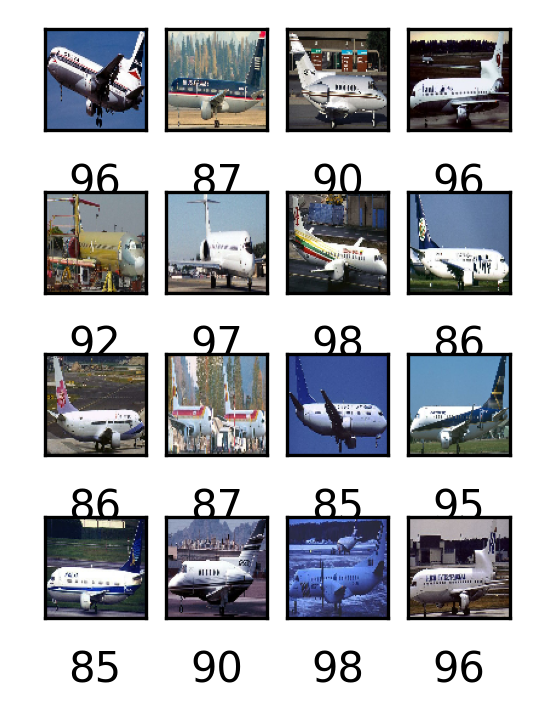

In [ ]:
N_BATCH = 1
one_dataset_batch = pipeline.make_one_source_batch_pipeline(
    dataset_spec=all_dataset_specs[0], batch_size=BATCH_SIZE, split=SPLIT,
    image_size=84, 
    shuffle_buffer_size=None
    )
for idx, (batch, source_id) in iterate_dataset(one_dataset_batch, N_BATCH):
  print('Batch-%d from source %s' % (idx, all_dataset_specs[source_id].name))
  plot_batch(*map(lambda a: a.numpy(), batch), size_multiplier=0.5)

# (3) Fixing Ways and Shots
1. `meta_dataset` library provides option to set number of classes/samples per episode. There are 3 main flags you can set. 
    - **NUM_WAYS**: Fixes the # classes per episode. We would still get variable number of samples per class in the support set.
    - **NUM_SUPPORT**: Fixes # samples per class in the support set.
    - **NUM_SUPPORT**: Fixes # samples per class in the query set.
2. If we want to use fixed `num_ways`, we have to disable ontology based sampling for omniglot and imagenet. We advise using single dataset for using this feature, since using multiple datasets is not supported/tested. In this notebook, we are using Quick, Draw! Dataset.
3. We sample episodes and visualize them as we did earlier.

In [ ]:
#1
NUM_WAYS = 5 #5 #8
NUM_SUPPORT = 5 #5 #8
NUM_QUERY = None #15 #5
fixed_ways_shots = config.EpisodeDescriptionConfig(
    num_ways=NUM_WAYS, num_support=NUM_SUPPORT, num_query=NUM_QUERY)

#2
use_bilevel_ontology_list = [False]*len(ALL_DATASETS)
use_dag_ontology_list = [False]*len(ALL_DATASETS)
quickdraw_spec = [all_dataset_specs[0]] # init specs[6]

#3
dataset_fixed = pipeline.make_multisource_episode_pipeline(
    dataset_spec_list=quickdraw_spec, 
    use_dag_ontology_list=[False],
    use_bilevel_ontology_list=use_bilevel_ontology_list, split=SPLIT,
    image_size=84, episode_descr_config=fixed_ways_shots)

N_EPISODES = 2
for idx, (episode, source_id) in iterate_dataset(dataset_fixed, N_EPISODES):
  print('Episode id: %d from source %s' % (idx, quickdraw_spec[source_id].name))
  episode = [a.numpy() for a in episode]
  plot_episode(support_images=episode[0], support_class_ids=episode[2],
               query_images=episode[3], query_class_ids=episode[5])

# (4) Using Meta-dataset with PyTorch
As mentioned above it is super easy to consume `meta_dataset` as NumPy arrays. This also enables easy integration into other popular deep learning frameworks like PyTorch. TensorFlow code processes the data and passes it to PyTorch, ready to be consumed. Since the data loader and processing steps do not have any operation on the GPU, TF should not attempt to grab the GPU, and it should be available for PyTorch.
1. Let's use an episodic dataset created earlier, `dataset_episodic`, and build on top of it. We will transpose tensor to CHW, which is the common order used by [convolutional layers](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.functional.conv2d) of PyTorch. 
2. We will use zero-indexed labels, therefore grabbing `e[1]` and `e[4]`. At the end we return a generator that consumes the `tf.Dataset`. 
3. Using `.cuda()` on PyTorch tensors should distribute them to appropriate devices.


In [ ]:
if torch.cuda.is_available():
    device = "cuda:0"
else : 
    device = "cpu"

In [ ]:
import torch
# 1
to_torch_labels = lambda a: torch.from_numpy(a.numpy()).long()
to_torch_imgs = lambda a: torch.from_numpy(np.transpose(a.numpy(), (0, 3, 1, 2)))
# 2
def data_loader(n_batches):
  for i, (e, _) in enumerate(dataset_episodic):
    # print(_)
    if i == n_batches:
      break
    yield (to_torch_imgs(e[0]), to_torch_labels(e[1]),
           to_torch_imgs(e[3]), to_torch_labels(e[4]))

for i, batch in enumerate(data_loader(n_batches=3)):
  #3
  data_support, labels_support, data_query, labels_query = [x.to(device) for x in batch]
  print(data_support.shape, labels_support.shape, data_query.shape, labels_query.shape) 

<h1>Add Pretrained Model </h1>


In [ ]:
import matplotlib.pyplot
import numpy.random
import torch.utils.data
import torchvision
import torch
# import torch.nn as nn 
from torchvision import datasets, transforms
from torch import Tensor
from torch.nn import Module
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.models import resnet18, resnet50, resnet152, resnet101, resnet34
from torchvision import models
from tqdm import tqdm
# from torch import nn, optim

from copy import deepcopy
import torch.nn as nn
import torch.jit
import torch.optim as optim
from torch.nn import functional as F

In [ ]:
device

'cuda:0'

In [ ]:
#1

NUM_SUPPORT = 10 #5 #8 # same as the number of shot 
NUM_WAYS = 5 #5 #8 #8 don't work with fungi
NUM_QUERY = 10 #5 #5
# NUM_QUERY = None #5 #5

#2
use_bilevel_ontology_list = [False]*len(ALL_DATASETS)
use_dag_ontology_list = [False]*len(ALL_DATASETS)
fixed_ways_shots = config.EpisodeDescriptionConfig(num_ways=NUM_WAYS, num_support=NUM_SUPPORT, num_query=NUM_QUERY, )

# specific_spec = [all_dataset_specs[0]] # aircraft
# specific_spec = [all_dataset_specs[1]] # birds
# specific_spec = [all_dataset_specs[5]] # flowers
# specific_spec = [all_dataset_specs[4]] # omniglot
specific_spec = [all_dataset_specs[2]] # dtd
# specific_spec = [all_dataset_specs[3]] # fungi

#3
dataset_fixed = pipeline.make_multisource_episode_pipeline(
    dataset_spec_list=specific_spec, 
    use_dag_ontology_list=[False],
    use_bilevel_ontology_list=use_bilevel_ontology_list, 
    split=SPLIT,
    image_size=160, 
    episode_descr_config=fixed_ways_shots,
    shuffle_buffer_size=None,
)

In [ ]:
def load_data(episodic_dataset, n_batches):
  for i, (e, _) in enumerate(episodic_dataset):
    if i == n_batches:
      break
    yield (to_torch_imgs(e[0]), to_torch_labels(e[1]), to_torch_labels(e[2]),
           to_torch_imgs(e[3]), to_torch_labels(e[4]), to_torch_labels(e[5]))

In [ ]:

N_EPISODES = 5
for idx, (episode, source_id) in iterate_dataset(dataset_fixed, N_EPISODES):
  print('Episode id: %d from source %s' % (idx, specific_spec[source_id].name))
  print(source_id)
  episode = [a.numpy() for a in episode]
  plot_episode(support_images=episode[0], support_class_ids=episode[2],
               query_images=episode[3], query_class_ids=episode[5])

#update the last layer of this models and train again with the support set of the test task,
# in order to have a new model. and passe this model to tent.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import copy

# class BatchTransNorm(nn.BatchNorm2d):
class BT2d(nn.BatchNorm2d):
    def __init__(self,
                 num_features: int,
                 eps: float = 1e-5,
                 momentum: float = 0.1,
                 affine: bool = True,
                 track_running_stats: bool = True):
        super(BT2d, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)

    # VDT Forward
    def forward(self, target_input):
        exponential_average_factor = self.momentum
        
        target_mean = target_input.mean([0, 2, 3])
        target_var = target_input.var([0, 2, 3], unbiased=False)
        
        n = target_input.numel() / target_input.size(1)
        with torch.no_grad():
            running_target_mean = exponential_average_factor * target_mean\
                + (1 - exponential_average_factor) * self.running_mean  
            # update running_var with unbiased var
            running_target_var = exponential_average_factor * target_var * n / (n - 1)\
                + (1 - exponential_average_factor) * self.running_var

            running_target_var = running_target_var[None, :, None, None]
            running_target_mean = running_target_mean[None, :, None, None]
            
            source_var = self.running_var[None, :, None, None]
            source_mean = self.running_mean[None, :, None, None]
            
            weight = self.weight[None, :, None, None]
            bias = self.bias[None, :, None, None]
            
            #  transfer
            target_input = (target_input - running_target_mean) * (torch.sqrt(source_var + self.eps) /
                                                           torch.sqrt(running_target_var + self.eps)) + source_mean
            
            transferred_mean = target_input.mean([0, 2, 3])[None, :, None, None]
            transferred_var = target_input.var([0, 2, 3], unbiased=False)[None, :, None, None]
            
            running_transferred_mean = exponential_average_factor * transferred_mean\
                + (1 - exponential_average_factor) * self.running_mean[None, :, None, None]
            # update running_var with unbiased var
            running_transferred_var = exponential_average_factor * transferred_var * n / (n - 1)\
                + (1 - exponential_average_factor) * self.running_var[None, :, None, None]
            
            target_input = (weight * (target_input - running_transferred_mean) /
                            (torch.sqrt(running_transferred_var + self.eps))) + bias
                        
            return target_input



In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
# from torchvision.models.utils import load_state_dict_from_url
from torch.hub import load_state_dict_from_url

from typing import Type, Any, Callable, Union, List, Optional
# from Batchtransfer_EMA import BatchTransNorm as BT2d


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-b627a593.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-63fe2227.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-394f9c45.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = BT2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BT2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BT2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = BT2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = BT2d(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = BT2d(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = BT2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = BT2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = BT2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (BT2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                BT2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18_vdb(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    # print("before init resnet 18")
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34_vdb(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50_vdb(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101_vdb(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152_vdb(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d_vdb(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d_vdb(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2_vdb(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2_vdb(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [ ]:
class MyLinearLayer2(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out, support_labels, C, bias):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out

        self.bias = nn.Parameter(bias)
        self.support_images = support_images
        self.support_labels = support_labels
        self.weight = nn.Parameter(C)

    def forward(self, x):
        w_times_x = 2 * torch.mm(x, self.weight.t())
        out = torch.add(w_times_x, self.bias)  # w times x + b
        return out


class MyLinearLayer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out, support_images, support_labels):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        # weights = torch.Tensor(size_out, size_in)
        bias = torch.Tensor(size_out)

        # self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.
        self.bias = nn.Parameter(bias)
        self.support_images = support_images
        self.support_labels = support_labels
        self.embed_support = False
        self.prototypes = None
        self.weight = nn.Parameter(torch.zeros_like(torch.empty(size_out, size_in)))

    def forward(self, x):
        if not self.embed_support:
            # self.prototypes = x
            x = x.detach()
            weight = torch.cat(
                [
                    x[torch.nonzero(self.support_labels == label)].mean(0)
                    for label in range(self.size_out)
                ]
            )
            bias = - torch.square(torch.norm(weight, dim=1))
            self.bias = nn.Parameter(bias)
            self.weight = nn.Parameter(weight)
            self.embed_support = True

        w_times_x = 2 * torch.mm(x, self.weight.t())
        out = torch.add(w_times_x, self.bias)  # w times x + b
        return out

In [ ]:
model = resnet18(pretrained=True, progress = True)

In [ ]:
def torch_compute_confidence_interval(data, confidence=0.95):
    """
    Computes the confidence interval for a given survey of a data set.
    """
    n = len(data)
    mean = data.mean()
    se = data.std() / (n**0.5)
    t_p  = 1.960
    ci = t_p * se
    return mean, ci

In [ ]:
def evaluate_on_one_task(
    model,
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.to(device), support_labels.to(device), query_images.to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(device)
    ).sum().item(), len(query_labels)


class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

In [ ]:
import gc
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
if device == 'cuda':
  torch.cuda.empty_cache()
  gc.collect()



In [ ]:
EPISODES = 200

pretrained = resnet18_vdb(pretrained=True)

convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
# convolutional_network.fc = nn.Identity()
proto_model = PrototypicalNetworks(convolutional_network).to(device)

# print('after')
pretrained.to(device)
in_features = pretrained.fc.in_features
# print('last layer input size', in_features)

proto_acc = []
pretrained_acc = []
copied_model = []
LR = 1

for i, episode in tqdm(enumerate(load_data(dataset_fixed, n_batches=EPISODES)), total=EPISODES):
    support_images, support_labels, support_class_ids, query_images, query_labels, query_class_ids = [x.to(device) for x in episode]
    # print(support_images.shape, query_images.shape)
    pretrained.fc = nn.Identity()
    embed_x = pretrained(support_images)
    C = torch.cat(
        [
            embed_x[torch.nonzero(support_labels == label)].mean(0)
            for label in range(NUM_WAYS)
        ]
    )
    bias = - torch.square(torch.norm(C, dim=1))
    pretrained.fc = MyLinearLayer2(in_features, NUM_WAYS, support_labels, C.detach(),  bias.detach())
    out1 = pretrained(query_images)
    pred1 = out1.argmax(dim=1, keepdim=True)
    correct1 = pred1.cpu().eq(query_labels.detach().cpu().view_as(pred1)).sum().item()

    correct, total = evaluate_on_one_task(
        proto_model, support_images, support_labels, query_images, query_labels
    )
    percent = 100.0 * correct / total
    percent1 = 100.0 * correct1 / total

    # print(percent, 'proto')
    # print(percent1, 'pretrained')
    proto_acc.append(percent)
    pretrained_acc.append(percent1)

proto_array = np.array(proto_acc)
pretrained_array = np.array(pretrained_acc)

mean_proto, ci_proto = torch_compute_confidence_interval(proto_array)
mean_pretrained, ci_pretrained = torch_compute_confidence_interval(pretrained_array)

print('*'*20)
print(mean_pretrained, "±", ci_pretrained, "Mean of the Pretrained Model")
print(mean_proto, "±", ci_proto, "Mean of PROTO Model")
print('*'*20)
# print(np.array(proto_acc).mean(), "Mean of Proto Model")
# print(np.array(pretrained_acc).mean(), "Mean of the Pretrained Model")
# print(np.array(copied_model).mean(), "Mean of the Copied Model")


100%|██████████| 200/200 [01:20<00:00,  2.50it/s]

********************
72.65 ± 1.1710692464581245 Mean of the Pretrained Model
67.15 ± 1.2796976439768886 Mean of PROTO Model
********************


93.57 Mean of Proto Model <br/>
93.86 Mean of the Pretrained Model
********************

In [ ]:
print(model_urls)
model_urls['resnet18']

{'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth', 'resnet34': 'https://download.pytorch.org/models/resnet34-b627a593.pth', 'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth', 'resnet101': 'https://download.pytorch.org/models/resnet101-63fe2227.pth', 'resnet152': 'https://download.pytorch.org/models/resnet152-394f9c45.pth', 'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth', 'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth', 'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth', 'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth'}


'https://download.pytorch.org/models/resnet18-f37072fd.pth'

In [ ]:
EPISODES = 10

pretrained = resnet18_vdb(pretrained=True)

convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
proto_model = PrototypicalNetworks(convolutional_network).to(device)


convolution_vdb_weigh_model  = resnet18(pretrained=False)
state_dict = load_state_dict_from_url(model_urls['resnet18'],)
convolution_vdb_weigh_model.load_state_dict(state_dict)
convolution_vdb_weigh_model.fc = nn.Flatten()
proto_vdb_weigh_model = PrototypicalNetworks(convolution_vdb_weigh_model).to(device)

# print('after')
pretrained.to(device)
in_features = pretrained.fc.in_features
# print('last layer input size', in_features)

proto_acc = []
pretrained_acc = []
copied_model = []
LR = 1

for i, episode in tqdm(enumerate(load_data(dataset_fixed, n_batches=EPISODES)), total=EPISODES):
    support_images, support_labels, support_class_ids, query_images, query_labels, query_class_ids = [x.to(device) for x in episode]
    correct, total = evaluate_on_one_task(
        proto_model, support_images, support_labels, query_images, query_labels
    )
    percent = 100.0 * correct / total

    correct_vdb, total_vdb = evaluate_on_one_task(
        proto_vdb_weigh_model, support_images, support_labels, query_images, query_labels
    )

    percent = 100.0 * correct / total
    percent_vdb = 100.0 * correct_vdb / total_vdb
    print(percent, 'proto')
    print(percent_vdb, 'vdb weigh')
    print('+'*3)

 10%|█         | 1/10 [00:01<00:09,  1.09s/it]

62.0 proto
62.0 vdb weigh
+++


 20%|██        | 2/10 [00:01<00:06,  1.32it/s]

50.0 proto
50.0 vdb weigh
+++


 30%|███       | 3/10 [00:02<00:04,  1.57it/s]

66.0 proto
66.0 vdb weigh
+++


 40%|████      | 4/10 [00:02<00:03,  1.76it/s]

64.0 proto
64.0 vdb weigh
+++


 50%|█████     | 5/10 [00:02<00:02,  2.12it/s]

72.0 proto
72.0 vdb weigh
+++


 60%|██████    | 6/10 [00:03<00:01,  2.55it/s]

58.0 proto
58.0 vdb weigh
+++


 70%|███████   | 7/10 [00:03<00:01,  2.74it/s]

76.0 proto
76.0 vdb weigh
+++


 80%|████████  | 8/10 [00:03<00:00,  2.86it/s]

72.0 proto
72.0 vdb weigh
+++


 90%|█████████ | 9/10 [00:03<00:00,  3.11it/s]

60.0 proto
60.0 vdb weigh
+++


100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

66.0 proto
66.0 vdb weigh
+++
